In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# read file
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# check file (dataset from kaggle Natural Language Processing with Disaster Tweets)
print("train data:", len(train))
print("test data:", len(test))

# check train data distribution
count_0 = (train['target'] == 0).sum()
count_1 = (train['target'] == 1).sum()
print("\nreal disasters [1]:", count_1, "| percentage", round(count_1/len(train)*100,4),"%")
print("non-real disasters [0]:", count_0, "| percentage", round(count_0/len(train)*100,4),"%")

train data: 7613
test data: 3263

real disasters [1]: 3271 | percentage 42.966 %
non-real disasters [0]: 4342 | percentage 57.034 %


In [3]:
# Split the train data. 70% for train, 30% for test
# random seed 666

train_set, dev_set = train_test_split(train, test_size=0.3, random_state=666)
print("train_set data: ", len(train_set))
print("dev_set data: ", len(dev_set))

train_set data:  5329
dev_set data:  2284


In [4]:
train_set.head()

,id,keyword,location,text,target
3979,5655,flooding,belleville,@kwislo I see her flooding at mad decent,0
4746,6751,lightning,"Coventry, UK",dogs Lightning reshapes rocks at the atomic le...,0
1522,2198,catastrophic,Planet Earth,Learning from the Legacy of a Catastrophic Eru...,1
3937,5598,flood,New York,Spot Flood Combo 53inch 300W Curved Cree LED W...,0
5825,8317,rubble,ON,China's Stock Market Crash: Are There Gems In ...,1


In [ ]:
dev_set.head()

,id,keyword,location,text,target
7008,10047,twister,NaN,@rodarmer21 10 dolla says wicked twister won't...,0
6872,9853,trauma,NaN,Today was trauma on top of trauma on top of t...,0
1342,1940,burning%20buildings,NaN,Hero's fight wars and save ppl from burning bu...,0
661,956,blaze,PA,pic of me and blaze in a fort when we were kid...,0
1605,2317,collapse,"Los Angeles, CA",What would you do if you were trapped in a col...,0


### Data Preprocessing

In [6]:
# Preprocess the data:
# 1.Convert all words to lowercase
# 234.Remove useless symbol # @username
# 5.Remove extra space and newline \n
# 6.Remove pure numbers, except 4digit year like 1987 2001
# 7.Lemmatization/Stemming (e.g. we are run => we are running)
# Stemming will lose many meanings, so not in use

import re
from nltk.stem import WordNetLemmatizer, PorterStemmer

# initialize lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_text(s, use_lemmatization=True, use_stemming=False):
    s = s.lower()                                # 1. lowercase
    s = re.sub(r"http\S+|www\.\S+", " ", s)      # 2. remove URL
    s = re.sub(r"@\S+", " ", s)                  # 3. remove @username
    s = s.replace("#", " ")                      # 4. remove #
    s = " ".join(s.split())                      # 5. remove extra space and \n

    s = re.sub(r"\b(?!\d{4}\b)\d+\b", " ", s)    # 6. remove pure numbers except 4digit year like 1987
    
    words = s.split()                            # 7. Lemmatization
    if use_lemmatization:
        words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatization
    elif use_stemming:
        words = [stemmer.stem(word) for word in words]  # stemming not in use
        
    s = " ".join(words) #Rearrange the words and form a sentence.
    
    return s

In [7]:
# clean text
train_set["clean_text"] = train_set["text"].apply(clean_text)
dev_set["clean_text"]   = dev_set["text"].apply(clean_text)

In [ ]:
# [check]
# sample check
sample_text = train_set["text"].iloc[1]  # pick second text in dataset
cleaned_text = clean_text(sample_text, use_lemmatization=True, use_stemming=False)

print("Original Text:\n ", sample_text)
print("\nCleaned Text:\n", cleaned_text)

Original Text:
  dogs Lightning reshapes rocks at the atomic level - A lightning strike can reshape a mineral's crystal structure ... http://t.co/2Wvmij5SA4

Cleaned Text:
 dog lightning reshapes rock at the atomic level - a lightning strike can reshape a mineral's crystal structure ...


### 1.Bag of Words model (Unigram, one word)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

# words appears in at least 'min_df' times documents/texts
# (min_df = M (threshold) need to adjust) usually 2~5
M = 2

# binary=True: Convert to binary features shown/not shown, not counting
# stop_words='english': meaningless words to model like "the", "and", "is", "to", "of"
vectorizer = CountVectorizer(binary=True, min_df = M, stop_words='english')

# Training feature matrix
X_train = vectorizer.fit_transform(train_set["clean_text"]) # Learn vocabulary list & transform train data
X_dev = vectorizer.transform(dev_set["clean_text"]) # apply exist vocabulary list to transform dev data

print("train_set Matrix shape", X_train.shape)
print("dev_set Matrix shape", X_dev.shape)

train_set Matrix shape (5329, 4473)
dev_set Matrix shape (2284, 4473)


In [10]:
# [check]
# vocabulary check
vocab = vectorizer.get_feature_names_out()
print("\nVocabulary List (first 200 words):")
print(vocab[:200])


Vocabulary List (first 200 words):
['1000' '10km' '10pm' '10th' '1141' '1200' '15pm' '15th' '1600' '1620'
 '16yr' '1880' '18w' '1945' '1965' '1976' '1980' '1986' '1998' '1999' '1a'
 '1st' '2005' '2007' '2009' '2010' '2011' '2012' '2013' '2014' '2015'
 '2016' '2030' '23km' '2nd' '2pcs' '2pm' '300w' '30pm' '360wisenews' '3g'
 '3m' '3rd' '3x' '4000' '43rd' '4500' '45pm' '4km' '4th' '4wd' '4x4'
 '5000' '53inch' '5c' '5km' '5pm' '5sos' '5th' '60mph' '61st' '6th' '70th'
 '72w' '7a' '8th' '8whts' '9000' '90blks' '9am' 'a1' 'a5' 'aa' 'ab' 'aba'
 'abandon' 'abandoned' 'abbott' 'abbswinston' 'abc' 'abcnews' 'abe'
 'ablaze' 'able' 'abomination' 'abortion' 'absolute' 'absolutely'
 'abstorm' 'abuse' 'abused' 'abusing' 'ac' 'acc' 'accept' 'access'
 'accident' 'accidentally' 'accidents' 'according' 'account' 'accused'
 'accuses' 'accustomed' 'acoustic' 'acre' 'acres' 'act' 'acted' 'acting'
 'action' 'activated' 'activates' 'active' 'activity' 'actual' 'actually'
 'acute' 'ad' 'adam' 'add' 'added' 'a

### Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import numpy as np

# Logistic Regression (Classification algorithms) calculates probabilities based on word frequencies
# using Sigmoid σ(z) = 1/(1+e^-z), >= 0.5 means disaster[1], <0.5 means non-disaster[0]

# Label, put target on y which is 1 demension, know if tweet is disaster
# 1 is disaster, 0 is not disaster
y_train = train_set["target"].values
y_dev   = dev_set["target"].values

In [12]:
# 1) No extra penalty
# No extra penalty, min loss function, max iterations is 1000
logreg_none = LogisticRegression(penalty=None, max_iter=1000, random_state=666)
logreg_none.fit(X_train, y_train) # use train data to train model
p_train = logreg_none.predict(X_train) # predict label in train data
p_dev   = logreg_none.predict(X_dev) # predict label in dev data
print(" Penalty = None")
print("train_set f1 score: ",f1_score(y_train, p_train))
print("dev_set   f1 score: ",f1_score(y_dev, p_dev))
print()

# 2) L1 regularization (lasso), improve generalization ability
logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=666)
logreg_l1.fit(X_train, y_train) # use train data to train model
p_train = logreg_l1.predict(X_train) # predict label in train data
p_dev   = logreg_l1.predict(X_dev) # predict label in dev data
print(" Penalty = L1")
print("train_set f1 score: ",f1_score(y_train, p_train))
print("dev_set   f1 score: ",f1_score(y_dev, p_dev))
print()

# 3) L2 regularization (Ridge), large penalty to weights, prevent overfitting
logreg_l2 = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000, random_state=666)
logreg_l2.fit(X_train, y_train) # use train data to train model
p_train = logreg_l2.predict(X_train) # predict label in train data
p_dev   = logreg_l2.predict(X_dev) # predict label in dev data
print(" Penalty = L2")
print("train_set f1 score: ",f1_score(y_train, p_train))
print("dev_set   f1 score: ",f1_score(y_dev, p_dev))
print()


 Penalty = None
train_set f1 score:  0.9784045835169678
dev_set   f1 score:  0.7109100050276521

 Penalty = L1
train_set f1 score:  0.8402925218211842
dev_set   f1 score:  0.7456331877729258

 Penalty = L2
train_set f1 score:  0.9041791734010621
dev_set   f1 score:  0.7574606619641888



['hiroshima', 'earthquake', 'forest', 'wildfire', 'bombing', 'flood', 'drought', 'spill', 'derailment', 'typhoon']
['better', 'electrocute', 'fuck', 'bitch', 'blew', 'book', 'phone', 'longer', 'character', 'drown']


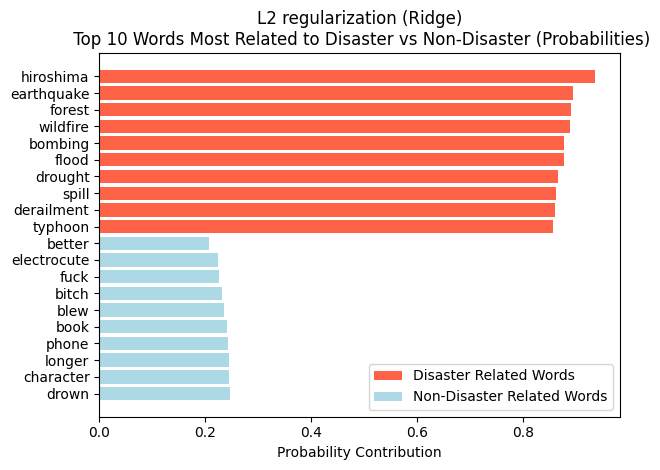

In [13]:
# [check]
# L2 model：important 10 words, and their relations with disaster/non-disaster

import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

feature_names = vectorizer.get_feature_names_out()
coef = logreg_l2.coef_[0]

top_pos_idx = np.argsort(coef)[-10:][::-1]  # words predict to be disaster 1
top_neg_idx = np.argsort(coef)[:10]         # words predict to be non-disaster 0

print([feature_names[i] for i in top_pos_idx])
print([feature_names[i] for i in top_neg_idx])

# sigmoid probability of top 10 pos/neg
probabilities = 1 / (1 + np.exp(-coef))  # Sigmoid calculation

top_pos_words = [feature_names[i] for i in top_pos_idx]
top_pos_probs = probabilities[top_pos_idx]

top_neg_words = [feature_names[i] for i in top_neg_idx]
top_neg_probs = probabilities[top_neg_idx]

# plot both pos/neg words probabilities barchart
plt.barh(top_pos_words, top_pos_probs, color='tomato', label='Disaster Related Words')
plt.barh(top_neg_words, top_neg_probs, color='lightblue', label='Non-Disaster Related Words')

plt.xlabel('Probability Contribution')
plt.title('L2 regularization (Ridge)\n Top 10 Words Most Related to Disaster vs Non-Disaster (Probabilities)')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 2.Bag-of-Words with N-gram features (1,2)
#### (Commonly use in Sentiment Analysis)
Emotions are typically expressed through combinations of words, this model can captures more contextual information

optimize vocabulary through Unigram：["I", "love", "programming"] --> Bigram：["I love", "love programming"]


In [14]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [15]:
# Logistic Regression (Classification algorithms) calculates probabilities based on word frequencies
# using Sigmoid σ(z) = 1/(1+e^-z), >= 0.5 means disaster[1], <0.5 means non-disaster[0]

# Label, put target on y which is 1 demension, know if tweet is disaster
# 1 is disaster, 0 is not disaster
y_train = train_set["target"].values
y_dev   = dev_set["target"].values

In [16]:
# words appears in at least 'min_df' times documents/texts
# (min_df = M (threshold) need to adjust) usually 2~5
M = 2

# binary=True: Convert to binary features shown/not shown, not counting
# stop_words='english': meaningless words to model like "the", "and", "is", "to", "of"
# ngram_range=(1,2): one word + two words vocabulory
# max_features used to limit noise
vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=M, stop_words='english', max_features=5000)

# Training feature matrix
X_train = vectorizer.fit_transform(train_set["clean_text"]) # Learn vocabulary list & transform train data
X_dev = vectorizer.transform(dev_set["clean_text"]) # apply exist vocabulary list to transform dev data

print("train_set Matrix shape", X_train.shape)
print("dev_set Matrix shape", X_dev.shape)

train_set Matrix shape (5329, 5000)
dev_set Matrix shape (2284, 5000)


In [17]:
# [check]
# vocabulary check
vocab = vectorizer.get_feature_names_out()
print("\nVocabulary List (first 200 words):")
print(vocab[:200])


Vocabulary List (first 200 words):
['1000' '10th' '1141 enrt' '1200' '15pm' '15th' '1600' '1620' '16yr'
 '16yr old' '1880' '1880 gem' '18w' '18w cree' '1945' '1965' '1976' '1980'
 '1980 prebreak' '1998' '1st' '2009' '2011' '2013' '2014' '2015'
 '2015 australia' '2015 pm' '2015 prebreak' '2nd' '2pcs' '2pcs 18w' '300w'
 '300w curved' '30pm' '3g' '3g time' '3rd' '4000' '4000 syrian' '43rd'
 '43rd ave' '4wd' '4wd flood' '4x4' '4x4 offroad' '5000' '53inch'
 '53inch 300w' '5km' '5km volcano' '5pm' '5th' '70th' '70th anniversary'
 'aa' 'aba' 'aba woman' 'abandoned' 'abandoned aircraft' 'abbott'
 'abbswinston' 'abbswinston zionist' 'abc' 'abc news' 'abe' 'ablaze'
 'able' 'abortion' 'absolutely' 'abstorm' 'abuse' 'abused' 'access'
 'access secret' 'accident' 'accident expert' 'accident man'
 'accident property' 'accidentally' 'accidents' 'accidents indian'
 'according' 'account' 'accuses' 'acre' 'acres' 'act' 'action'
 'action hostage' 'action year' 'activated' 'activates'
 'activates municipa

### Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import numpy as np

# Logistic Regression (Classification algorithms) calculates probabilities based on word frequencies
# using Sigmoid σ(z) = 1/(1+e^-z), >= 0.5 means disaster[1], <0.5 means non-disaster[0]

# Label, put target on y which is 1 demension, know if tweet is disaster
# 1 is disaster, 0 is not disaster
y_train = train_set["target"].values
y_dev   = dev_set["target"].values

In [19]:
# 1) No extra penalty
# No extra penalty, min loss function, max iterations is 1000
logreg_none = LogisticRegression(penalty=None, max_iter=1000, random_state=666)
logreg_none.fit(X_train, y_train) # use train data to train model
p_train = logreg_none.predict(X_train) # predict label in train data
p_dev   = logreg_none.predict(X_dev) # predict label in dev data
print(" Penalty = None")
print("train_set f1 score: ",f1_score(y_train, p_train), "| acc:", accuracy_score(y_train, p_train))
print("dev_set   f1 score: ",f1_score(y_dev, p_dev),  "| acc:", accuracy_score(y_dev, p_dev))
print()

# 2) L1 regularization (lasso), improve generalization ability
logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=666)
logreg_l1.fit(X_train, y_train) # use train data to train model
p_train = logreg_l1.predict(X_train) # predict label in train data
p_dev   = logreg_l1.predict(X_dev) # predict label in dev data
print(" Penalty = L1")
print("train_set f1 score: ",f1_score(y_train, p_train), "| acc:", accuracy_score(y_train, p_train))
print("dev_set   f1 score: ",f1_score(y_dev, p_dev),  "| acc:", accuracy_score(y_dev, p_dev))
print()

# 3) L2 regularization (Ridge), large penalty to weights, prevent overfitting
logreg_l2 = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000, random_state=666)
logreg_l2.fit(X_train, y_train) # use train data to train model
p_train = logreg_l2.predict(X_train) # predict label in train data
p_dev   = logreg_l2.predict(X_dev) # predict label in dev data
print(" Penalty = L2")
print("train_set f1 score: ",f1_score(y_train, p_train), "| acc:", accuracy_score(y_train, p_train))
print("dev_set   f1 score: ",f1_score(y_dev, p_dev),  "| acc:", accuracy_score(y_dev, p_dev))
print()


 Penalty = None
train_set f1 score:  0.9748010610079576 | acc: 0.9786076186901858
dev_set   f1 score:  0.717534108135422 | acc: 0.7552539404553416

 Penalty = L1
train_set f1 score:  0.8421800947867298 | acc: 0.8750234565584537
dev_set   f1 score:  0.7471074380165289 | acc: 0.7990367775831874

 Penalty = L2
train_set f1 score:  0.897126969416126 | acc: 0.9166823043723025
dev_set   f1 score:  0.7526055951727921 | acc: 0.8025394045534151



['hiroshima', 'forest', 'flood', 'wildfire', 'earthquake', 'drought', 'derailment', 'california', 'bombing', 'dy']
['better', 'electrocute', 'fuck', 'blew', 'bitch', 'character', 'aren', 'song', 'lol', 'ruin']


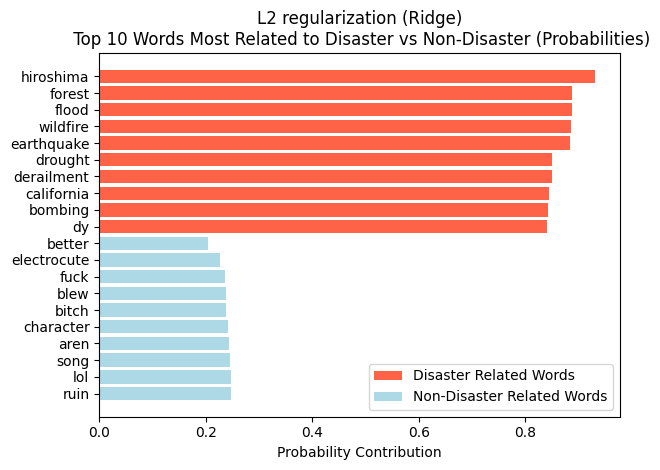

In [20]:
# [check]
# L2 model：important 10 words, and their relations with disaster/non-disaster

import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

feature_names = vectorizer.get_feature_names_out()
coef = logreg_l2.coef_[0]

top_pos_idx = np.argsort(coef)[-10:][::-1]  # words predict to be disaster 1
top_neg_idx = np.argsort(coef)[:10]         # words predict to be non-disaster 0

print([feature_names[i] for i in top_pos_idx])
print([feature_names[i] for i in top_neg_idx])

# sigmoid probability of top 10 pos/neg
probabilities = 1 / (1 + np.exp(-coef))  # Sigmoid calculation

top_pos_words = [feature_names[i] for i in top_pos_idx]
top_pos_probs = probabilities[top_pos_idx]

top_neg_words = [feature_names[i] for i in top_neg_idx]
top_neg_probs = probabilities[top_neg_idx]

# plot both pos/neg words probabilities barchart
plt.barh(top_pos_words, top_pos_probs, color='tomato', label='Disaster Related Words')
plt.barh(top_neg_words, top_neg_probs, color='lightblue', label='Non-Disaster Related Words')

plt.xlabel('Probability Contribution')
plt.title('L2 regularization (Ridge)\n Top 10 Words Most Related to Disaster vs Non-Disaster (Probabilities)')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [22]:
# C controls the strength of regularization, how much it trusts train data
# small C have stronger regularization, allows model to fit train data conservatively
# large C have less     regularization, allows model to fit train data more aggressively (might overfitting)

for C_num in [0.1, 0.3, 1, 3, 10]:
    model = LogisticRegression(
        penalty="l2",
        solver="liblinear",
        C=C_num,
        max_iter=1000,
        random_state=666
    )
    model.fit(X_train, y_train)
    pred_dev = model.predict(X_dev)
    print("C=", C_num,
          "dev_f1=", f1_score(y_dev, pred_dev),
          "dev_acc=", accuracy_score(y_dev, pred_dev))

C= 0.1 dev_f1= 0.734982332155477 dev_acc= 0.8029772329246935
C= 0.3 dev_f1= 0.7561114269471291 dev_acc= 0.8121716287215411
C= 1 dev_f1= 0.7526055951727921 dev_acc= 0.8025394045534151
C= 3 dev_f1= 0.7412209616423555 dev_acc= 0.7902802101576182
C= 10 dev_f1= 0.7337901950448076 dev_acc= 0.7788966725043783


In [28]:
# We find out when N-Gram, L2, C = 0.3, it's having better performance
# rebuilt model, ("vectorizer.fit_transform" will create new volcabulory list, so not use again)
logreg_l2 = LogisticRegression(
    penalty="l2",
    solver="liblinear",
    C=0.3,
    max_iter=1000,
    random_state=666
)

logreg_l2.fit(X_train, y_train) # use train data to train model

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.3
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,666
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


### 3. Predict disaster/non-disaster on test.csv, using exist N-gram L2 model

In [29]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

In [30]:
# load test.csv
test_set = pd.read_csv("test.csv")
# clean test.csv text
test_set["clean_text"] = test_set["text"].apply(clean_text)

In [31]:
test_set.head()

,id,keyword,location,text,clean_text
0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","heard about earthquake is different cities, st..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, goose are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting. spokane wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill in china and taiwan


In [32]:
# transform (use exist vocabulory list to turn test text into same column vector)
X_test = vectorizer.transform(test_set["clean_text"])

# predict disaster/non-disaster on test.csv
y_test_pred = logreg_l2.predict(X_test)

# generate submission.csv for kaggle competition
submission = pd.DataFrame({
    "id": test_set["id"],
    "target": y_test_pred
})

# save to current file path
submission.to_csv("submission.csv", index=False)
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


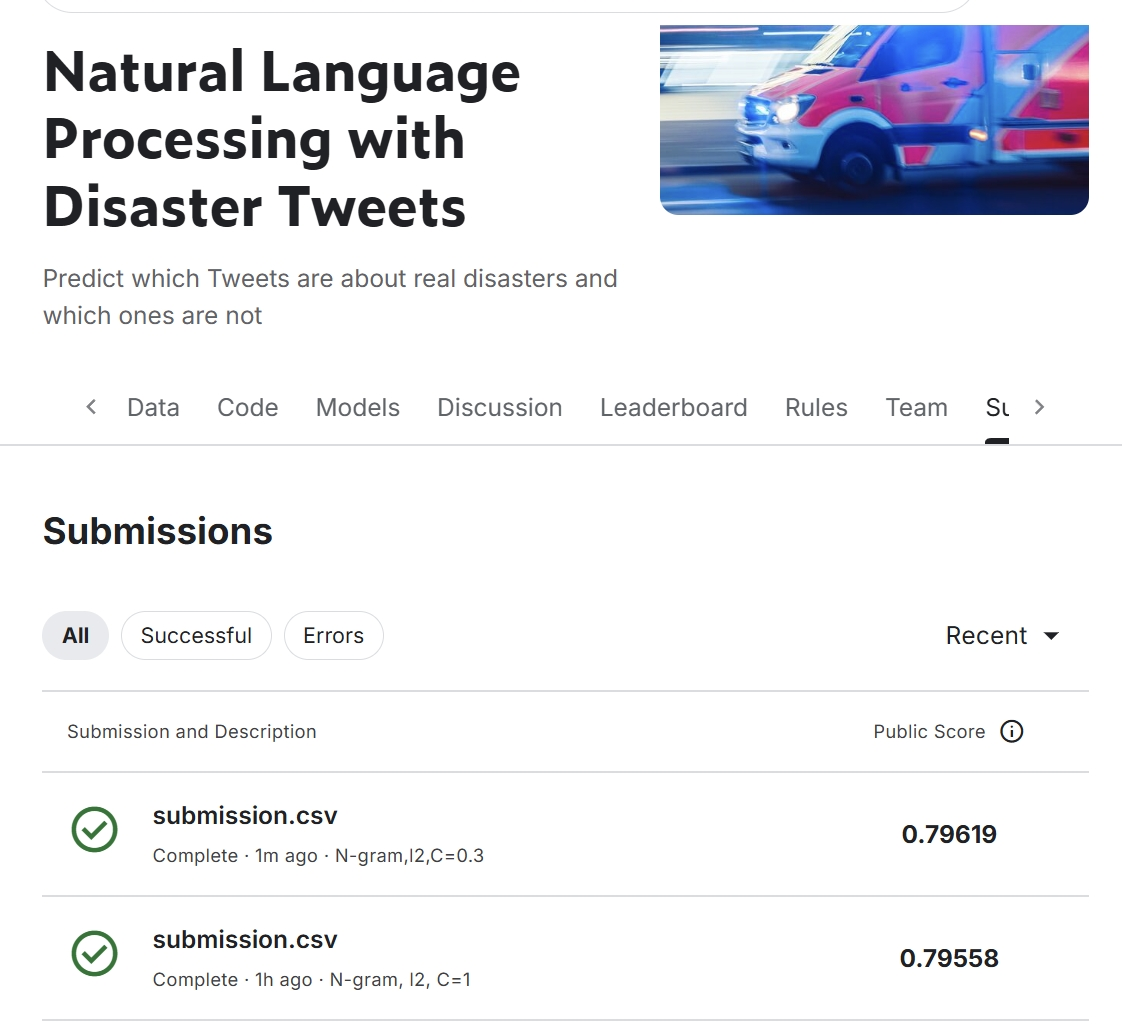